In [341]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict


from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [342]:
# test model
test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_HCP_half_2_NEOFAC_C'
dataset_test = 'cingulate_HCP_half_2_NEOFAC_O'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/train_val_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)

# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)

In [343]:
# print(train_df.head())
# print(test_df.head())
mean_label = prediction_df.label.mean()
def f(x):
    return 1 if x>=mean_label else 0
prediction_df_continuous = prediction_df.copy()
prediction_df.loc[:,"label"] = prediction_df.label.apply(f)
# prediction_df['label'] = np.random.permutation(prediction_df['label'].values)
prediction_df.index = prediction_df.index.astype(np.int64)

In [344]:
diff = test_df.index.difference(prediction_df.index)
test_df.drop(diff, inplace=True)
diff = prediction_df.index.difference(test_df.index)
prediction_df.drop(diff, inplace=True)

In [345]:
if len(test_df) != len(prediction_df):
    raise ValueError(f"len(test_df) = {len(test_df)} != len(prediction_df) = {len(prediction_df)}")

In [346]:

print(test_df.index.difference(prediction_df.index))
print(prediction_df.index.difference(test_df.index))
if len(test_df.index.difference(prediction_df.index)) or len(prediction_df.index.difference(test_df.index)):
    raise ValueError("Subjects are different in both dataframes")

Int64Index([], dtype='int64', name='ID')
Int64Index([], dtype='int64', name='Subject')


In [347]:
prediction_df.index

Int64Index([100206, 100408, 101006, 101410, 101915, 102109, 102311, 102715,
            103414, 103818,
            ...
            979984, 983773, 984472, 989987, 990366, 991267, 992673, 992774,
            995174, 996782],
           dtype='int64', name='Subject', length=548)

## UMAP

In [348]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [349]:
def visualize_umaps(model_path, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75], show_wrong_class=False, dataset='cingulate_ACCpatterns_1', verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/' + dataset + "_embeddings/full_embeddings.csv", index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path + '/' + dataset + "_embeddings/cross_val_predicted_labels.csv", index_col=0)
    prediction_df.sort_index(inplace=True)
    
    if verbose:
        print("Data df:")
        print(data_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
        
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    # plot for predicted labels
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_model_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):
            plt.subplot(n_i, n_j, i*n_j + j + 1)
            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]
            if show_wrong_class:
                colors = []
                # for i in range(prediction_df.shape[0]):
                #     if prediction_df[la]

            plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
            if i == n_i-1:
                plt.xlabel(f"Decision threshold = {threshold}")
            if j == 0:
                plt.ylabel(f"Model quality={quantile} (auc={model_auc})")
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()
            plt.title("Svm labels ; accuracy = {:.2f}".format(accuracy))
    plt.show()

    return pd.DataFrame(visual_embs, index=data_df.index.values)

In [350]:
def cross_correlation(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [351]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns_1'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [352]:
def full_visualization(model_path, dataset='cingulate_ACCpatterns_1'):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

In [353]:
# test model
# visual_embs = full_visualization(test_model)

# Visualize each variable of the latent

x, full_df and colors shapes:  (171, 10) (171, 11) (171, 10)
(10,) (10,) (10,)


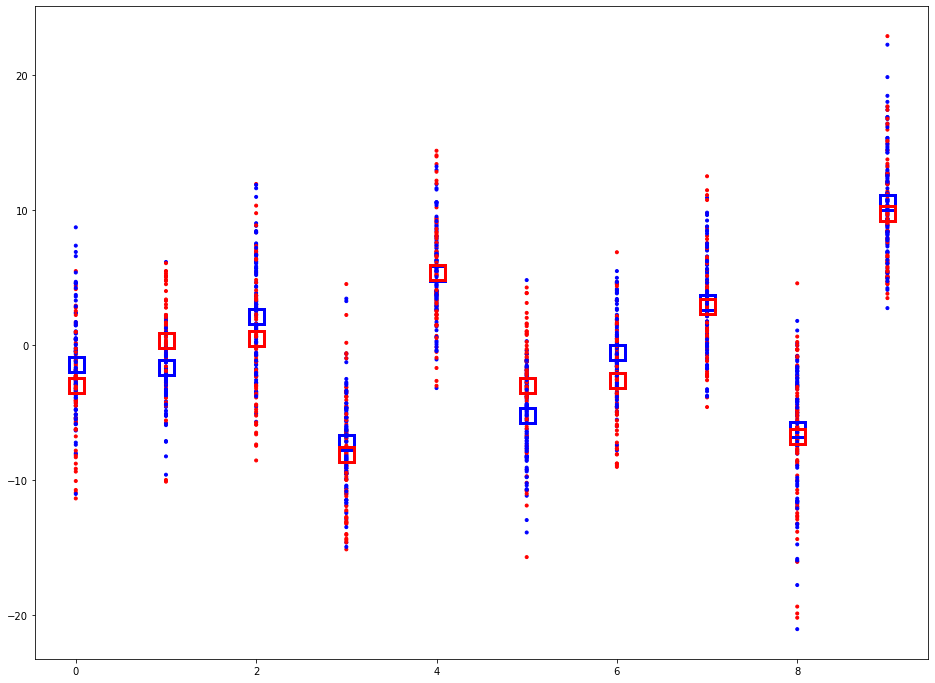

In [354]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [355]:
def do_pca(model_path, dataset=dataset_test):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


# Functions for dictionary learning

In [356]:
def do_dictionary_learning(data_df, n_components=10, transform_n_nonzero_coefs=1):
    data_df_local = data_df.copy()
    full_df_local = pd.DataFrame()
    # Makes dictionary learning over all embeddings
    latent_df = data_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components,
                                      transform_n_nonzero_coefs=transform_n_nonzero_coefs,
                                      alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = data_df_local.index
    full_df_local = pd.merge(data_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local, dict_learner

In [357]:
def test_dictionary_learning(dict_learner, test_df, n_components):
    test_df_local = test_df.copy()
    full_df_local = pd.DataFrame()
    latent_df = test_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    transformed = dict_learner.transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = test_df_local.index
    full_df_local = pd.merge(test_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local


In [358]:
def plot_patterns(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Transforms over label0 dataframe
    label0_df = full_df_local[full_df_local['label'] == 0].iloc[:,1:]
    transformed0 = label0_df.values

    # Transforms over label1 dataframe
    label1_df = full_df_local[full_df_local['label'] == 1].iloc[:,1:]
    transformed1 = label1_df.values

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

In [359]:
def return_predictions(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res = np.zeros(2*n_patterns)

    # Makes random permutation to produce random label
    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)

    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df_local[full_df_local[c] > 0.]
        res[2*i] = df['label'].mean()
        df = full_df_local[full_df_local[c] < 0.]
        res[2*i+1] = df['label'].mean()

    return res

def plot_predictions(prediction_df, transformed_df):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_random = np.zeros((20, 2*n_patterns))

    # Loads labels
    mean_label = prediction_df_local['label'].mean()
    print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res = return_predictions(prediction_df_local, transformed_df_local)
    for i in range(20):
        res_random[i,:] = return_predictions(prediction_df_local, transformed_df_local, True)
    
    for i in range(20):
        plt.scatter(x, res_random[i], c='grey')

    plt.scatter(x, res, c='red')
    plt.plot(mean_label*np.ones(2*n_patterns))
    plt.ylim((0,1))
    return res   

In [360]:
def return_sum(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res_sum = np.zeros(2*n_patterns)
    res_len = np.zeros(2*n_patterns)

    full_df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df[full_df[c] > 0.]
        res_sum[2*i] = df['label'].sum()
        res_len[2*i] = len(df)
        df = full_df[full_df[c] < 0.]
        res_sum[2*i+1] = df['label'].sum()
        res_len[2*i+1] = len(df)

    return res_sum, res_len


def do_t_test(prediction_df, transformed_df, show=True):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_p = np.zeros(2*n_patterns)

    # Mean labels
    mean_label = prediction_df_local['label'].mean()
    # print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res_sum, res_len = return_sum(prediction_df_local, transformed_df_local)
    
    for i in range(2*n_patterns):
        res_p[i] = binom_test(res_sum[i], n=res_len[i], p=mean_label, alternative='two-sided')

    if show:
        plt.scatter(x, -np.log10(res_p))
        plt.plot(-np.log10(0.005)*np.ones(2*n_patterns))

    return res_p   

In [361]:
def give_number_relevant_subjects(prediction_df, transformed_df, res_p, show=True):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if d.label.sum() < (len(d.label)/2.):
            d.iloc[:,i] = -d.iloc[:,i]
        d.iloc[:,i] = 1. / (1. + np.exp(d.iloc[:,i]))
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        if len(np.unique(d.label.values)) == 1:
            d.iloc[0,0] = 1-d.iloc[0,0]
            # auc_score[2*i-2] = 1.0
            # print(i, len(d), res_p[2*i-2], 1.0)
        # else:
        #     auc_score[2*i-2] = roc_auc_score(d.label, d.iloc[:,i])
            # print(i, len(d), res_p[2*i-2], roc_auc_score(d.label, d.iloc[:,i]))
        auc_score[2*i-2] = roc_auc_score(d.label, d.iloc[:,i])
        # auc_score[2*i-2] = roc_auc_score(d.label, d.iloc[:,i])
        if res_p[2*i-2] < 0.01:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)

        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if d.label.sum() >= (len(d.label)/2.):
            d.iloc[:,i] = -d.iloc[:,i]
        d.iloc[:,i] = 1. / (1. + np.exp(d.iloc[:,i]))
        nb_subjects[2*i-1] = len(d)
        if len(np.unique(d.label.values)) == 1:
            d.iloc[0,0] = 1-d.iloc[0,0]
        auc_score[2*i-1] = roc_auc_score(d.label, d.iloc[:,i])
        if res_p[2*i-1] < 0.01:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('auc_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return nb_subjects_relevant, max_auc_score

In [362]:
def give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, show=True):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    exact_nb_subjects_relevant = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        auc_score[2*i-2] = accuracy_score(d.label, d.iloc[:,i])
        if res_p[2*i-2] < 0.05:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)
            if 2.*d.label.sum() < (len(d.label)):
                exact_nb_subjects_relevant += len(d.label)-d.label.sum()
            else:
                exact_nb_subjects_relevant += d.label.sum()
        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        nb_subjects[2*i-1] = len(d)
        auc_score[2*i-1] = accuracy_score(d.label, d.iloc[:,i])
        if res_p[2*i-1] < 0.05:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            if 2.*d.label.sum() < (len(d.label)):
                exact_nb_subjects_relevant += len(d.label)-d.label.sum()
            else:
                exact_nb_subjects_relevant += d.label.sum()
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('accuracy_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return nb_subjects_relevant, max_auc_score, exact_nb_subjects_relevant

# Applying dictionary learning

In [363]:
full_train_df, transformed_train_df, dict_learner = do_dictionary_learning(data_df=train_df, n_components=5, transform_n_nonzero_coefs=1)

In [364]:
full_df, transformed_df = test_dictionary_learning(dict_learner=dict_learner, test_df=test_df, n_components=5)

In [365]:
print(full_df.head())

            dim1      dim2       dim3      dim4       dim5       dim6  \
ID                                                                      
100206  8.394083 -4.838112   6.458366 -3.329373  10.817843 -12.612897   
100408 -0.053095 -2.919907  -3.839787 -6.310361   0.392095  -7.196580   
101006  1.712571 -5.799995   4.553103 -0.968306  -1.620303  -2.390229   
101410  3.489696  4.495402 -11.340138 -4.255336   3.263800  -5.770106   
101915  3.194303  1.626097  10.028360 -8.020655   8.558414   0.001191   

            dim7      dim8       dim9      dim10   trans_0  trans_1  trans_2  \
ID                                                                             
100206  2.753505  7.109221 -12.640517  19.555060 -2.865014      0.0      0.0   
100408  0.992875  5.049739 -10.221111  13.107022  0.000000      0.0      0.0   
101006 -2.943960  4.531745 -18.519890  21.366726 -2.059972      0.0      0.0   
101410 -7.426247  3.433277 -10.003428   4.795885  0.000000      0.0      0.0   
101915 -

In [366]:
# prediction_df = prediction_df[np.square(transformed_df.trans_0)\
#                              +np.square(transformed_df.trans_1)\
#                             +np.square(transformed_df.trans_2)\
#                             +np.square(transformed_df.trans_3)\
#                             +np.square(transformed_df.trans_4) >1.0]

In [367]:
# prediction_df_continuous = prediction_df_continuous[np.square(transformed_df.trans_0)\
#                              +np.square(transformed_df.trans_1)\
#                             +np.square(transformed_df.trans_2)\
#                             +np.square(transformed_df.trans_3)\
#                             +np.square(transformed_df.trans_4) >1.0]

In [368]:
# transformed_df = transformed_df[np.square(transformed_df.trans_0)\
#                 +np.square(transformed_df.trans_1)\
#                 +np.square(transformed_df.trans_2)\
#                 +np.square(transformed_df.trans_3)\
#                 +np.square(transformed_df.trans_4) >1.0]

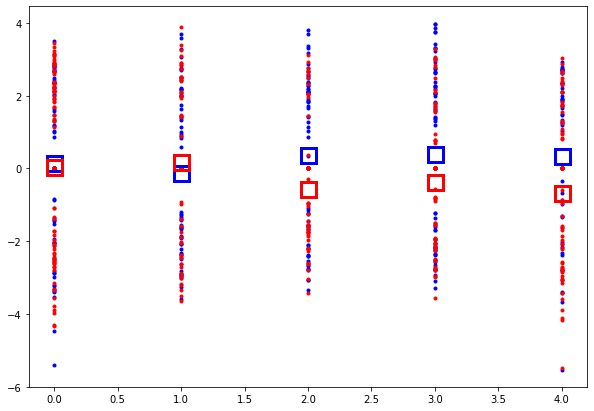

In [369]:
plot_patterns(prediction_df, transformed_df, random=False)

In [370]:
test_df.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10
ID,,,,,,,,,,
100206,8.394083,-4.838112,6.458366,-3.329373,10.817843,-12.612897,2.753505,7.109221,-12.640517,19.555060
100408,-0.053095,-2.919907,-3.839787,-6.310361,0.392095,-7.196580,0.992875,5.049739,-10.221111,13.107022
101006,1.712571,-5.799995,4.553103,-0.968306,-1.620303,-2.390229,-2.943960,4.531745,-18.519890,21.366726
101410,3.489696,4.495402,-11.340138,-4.255336,3.263800,-5.770106,-7.426247,3.433277,-10.003428,4.795885
101915,3.194303,1.626097,10.028360,-8.020655,8.558414,0.001191,-0.200929,3.515149,-7.476232,21.969023


In [371]:
transformed_df.head()

,trans_0,trans_1,trans_2,trans_3,trans_4
ID,,,,,
100206,-2.865014,0.0,0.0,0.000000,0.000000
100408,0.000000,0.0,0.0,0.000000,0.797902
101006,-2.059972,0.0,0.0,0.000000,0.000000
101410,0.000000,0.0,0.0,-2.649164,0.000000
101915,0.000000,0.0,0.0,0.000000,-1.973884


In [372]:
prediction_df[['label']].head()

,label
Subject,
100206,0.0
100408,1.0
101006,0.0
101410,0.0
101915,1.0


In [373]:
visu_df = pd.merge(prediction_df_continuous[['label']], transformed_df, left_index=True, right_index=True)
visu_df.head()
    

,label,trans_0,trans_1,trans_2,trans_3,trans_4
Subject,,,,,,
100206.0,23.0,-2.865014,0.0,0.0,0.000000,0.000000
100408.0,29.0,0.000000,0.0,0.0,0.000000,0.797902
101006.0,23.0,-2.059972,0.0,0.0,0.000000,0.000000
101410.0,26.0,0.000000,0.0,0.0,-2.649164,0.000000
101915.0,30.0,0.000000,0.0,0.0,0.000000,-1.973884


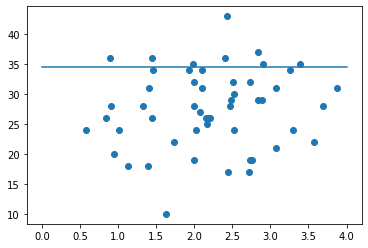

In [374]:
visu_df_relevant = visu_df[visu_df.trans_1 > 0.0]
plt.scatter(visu_df_relevant.trans_1, visu_df_relevant.label)
plt.plot([0,4], [34.5, 34.5])

In [375]:
# import seaborn as sns
# sns.pointplot(data=visu_df_relevant, x=visu_df_relevant.label, y="trans_1")

In [376]:
# plot_patterns(prediction_df, transformed_df, random=True)

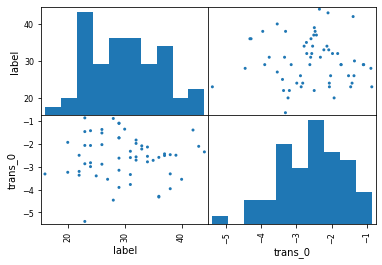

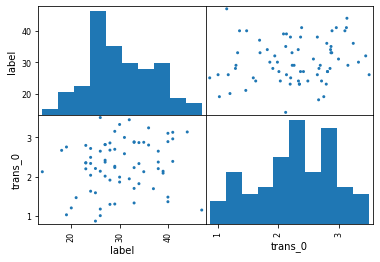

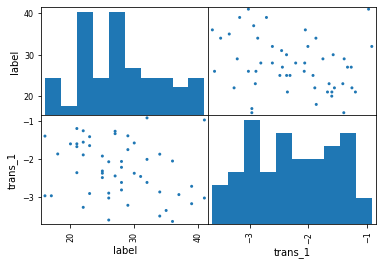

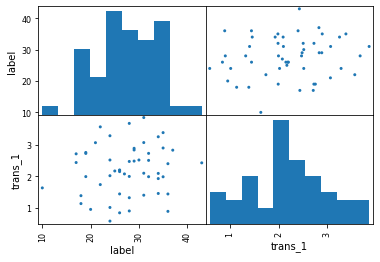

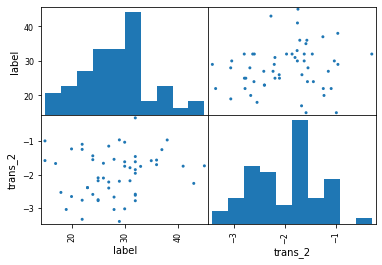

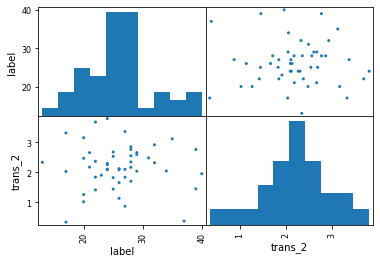

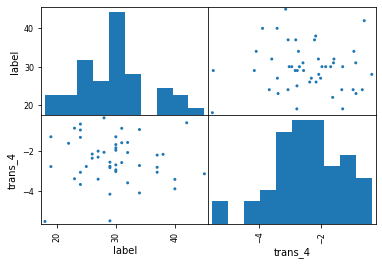

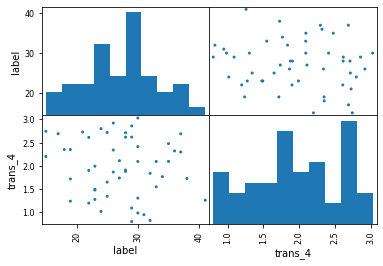

In [377]:
for trans in ["trans_0", "trans_1", "trans_2", "trans_4"]:
    for eps in [-1, 1]:
        pd.plotting.scatter_matrix(visu_df[visu_df[trans]*eps > 0.0][["label", trans]],
                                    alpha=1.0,
                                    diagonal="hist")
        plt.show()

In [378]:
from scipy.stats import mannwhitneyu

for trans in ["trans_0", "trans_1", "trans_2", "trans_4"]:
    for eps in [1, -1]:
        data1 = visu_df[visu_df[trans]*eps > 0.0][["label"]].values[:,0]
        data2 = visu_df[['label']].values[:,0]
        stat, p_value = mannwhitneyu(data1, data2)
        print(p_value, -np.log10(p_value))
print(-np.log10(0.05))
print(-np.log10(0.005))

0.015365339161495661 1.8134578490528757
0.03748025247920682 1.426197492225108
0.29786680150195743 0.5259778980200904
0.1806019555385296 0.7432775515031632
0.004993478674806239 2.301596800485509
0.42751798135835206 0.36904561417445186
0.1586778874208737 0.7994835901966558
0.08240006671475997 1.0840724366786076
1.3010299956639813
2.3010299956639813


In [384]:
visu_df.head()

,label,trans_0,trans_1,trans_2,trans_3,trans_4
Subject,,,,,,
100206.0,23.0,-2.865014,0.0,0.0,0.000000,0.000000
100408.0,29.0,0.000000,0.0,0.0,0.000000,0.797902
101006.0,23.0,-2.059972,0.0,0.0,0.000000,0.000000
101410.0,26.0,0.000000,0.0,0.0,-2.649164,0.000000
101915.0,30.0,0.000000,0.0,0.0,0.000000,-1.973884


In [379]:
visu_df.to_csv(f"{test_model}/visu_{dataset_test}.csv")

In [385]:
cramer = np.load(f"{test_model}/cramer_{dataset_test}.npy")

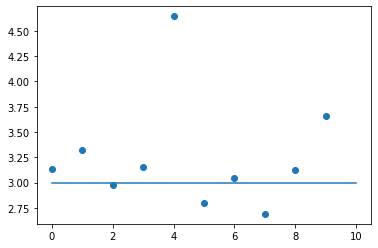

In [386]:
plt.scatter(np.arange(0,10), cramer)
plt.plot([0,10], [-np.log10(0.001), -np.log10(0.001)])

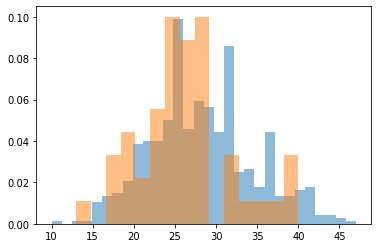

In [396]:
a = plt.hist(visu_df.label, density=True, alpha=0.5, bins=30)
v = visu_df[visu_df.trans_2>0.]
b = plt.hist(v.label, density=True, alpha=0.5, bins=15)

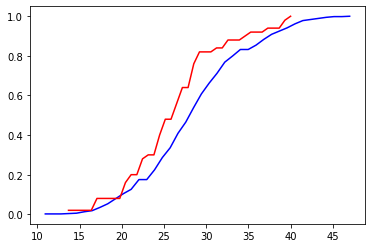

In [394]:
count, bins_count = np.histogram(visu_df.label, bins=40)
pdf = count/sum(count)
cdf_all = np.cumsum(pdf)
count, bins_count_col = np.histogram(v.label, bins=40)
pdf = count/sum(count)
cdf_col = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf_all, color="blue", label="all")
plt.plot(bins_count_col[1:], cdf_col, color="red", label="spec")

In [380]:
test_model

'/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/chosen_model/chosen_model'

array([[<AxesSubplot:xlabel='label', ylabel='label'>,
        <AxesSubplot:xlabel='trans_2', ylabel='label'>],
       [<AxesSubplot:xlabel='label', ylabel='trans_2'>,
        <AxesSubplot:xlabel='trans_2', ylabel='trans_2'>]], dtype=object)

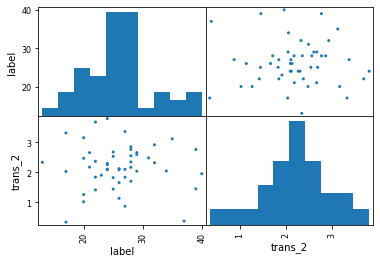

In [389]:
pd.plotting.scatter_matrix(visu_df[visu_df["trans_2"] > 0.0][["label", "trans_2"]],
                                    alpha=1.0,
                                    diagonal="hist")

Mean label = 0.46167883211678834


array([0.54929577, 0.60344828, 0.44230769, 0.39215686, 0.24      ,
       0.48148148, 0.33928571, 0.49122807, 0.43137255, 0.60416667])

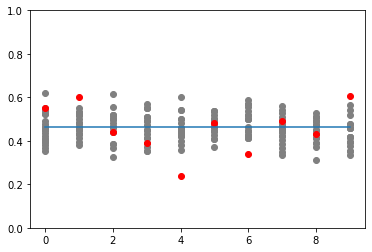

In [381]:
plot_predictions(prediction_df, transformed_df)

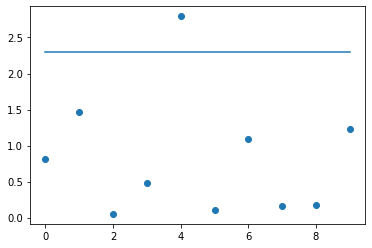

In [382]:
res_p = do_t_test(prediction_df, transformed_df)

(108.0, 0.76, 73.0)

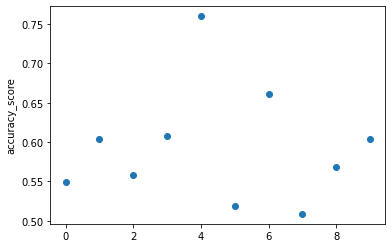

In [383]:
give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p)